In [4]:
%load_ext autoreload
%autoreload 2

# hardware
import os
# analysis
import numpy as np
import xarray as xr
import pandas as pd
from scipy.integrate import simps
from scipy.interpolate import RegularGridInterpolator
# vis
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')

# Acoustic tomography package
import atom
# configuration object
from hydra import initialize, compose
from hydra.utils import instantiate
with initialize(version_base=None, config_path="../../conf/"):
    cfg = compose(config_name="configs",)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
datapath = "../../../data/processedData/"
files = os.listdir(datapath)
ATfiles = [datapath+x for x in files if 'arrayOutput' in x]
auxfiles = [datapath+x for x in files if 'auxdata' in x]

ATfiles.sort()
auxfiles.sort()

auxfiles.pop(0)
ATfiles.pop(0)

In [56]:
atdat = xr.open_mfdataset(ATfiles, chunks=None)

auxdat = []

for file in auxfiles:
    auxdat.append(xr.load_dataset(file))
    
auxdat = xr.concat(auxdat, dim='time')
auxdat = auxdat.sortby('time')
auxdat2 = auxdat.resample(time='0.5S').mean()

auxdat2.coords['frame'] = np.arange(auxdat2.u.shape[0])
auxdat2 = auxdat2.assign_coords(time = np.arange(auxdat2.u.shape[0]))

In [58]:
atDat = atdat[['u','v','c']].to_dataframe().to_xarray()

auxdat = auxdat2[['ux','uy']].to_dataframe().to_xarray()

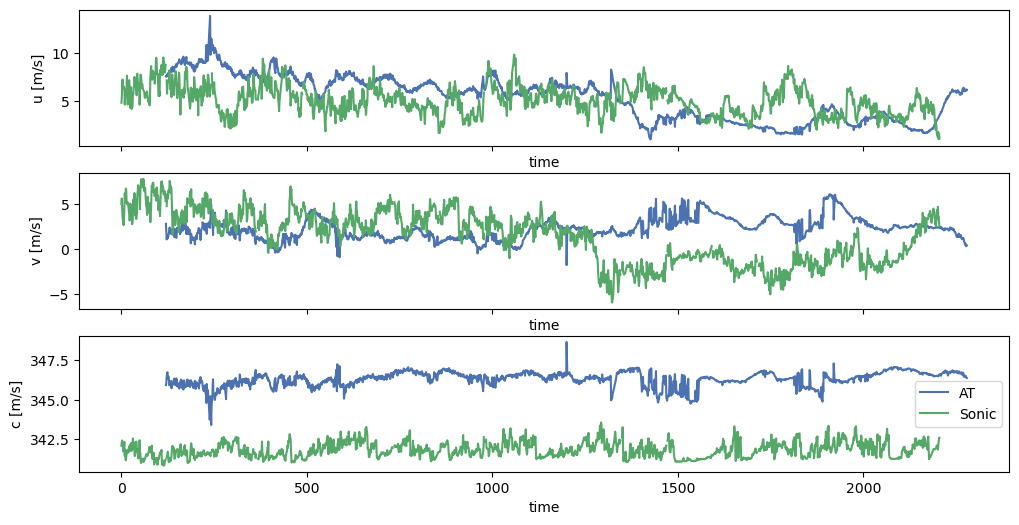

In [59]:
fig, ax = plt.subplots(3,1,sharex=True, figsize=(12,6))

atDat.u.plot(ax=ax[0], label='AT')
auxdat2.u.plot(ax=ax[0], label='Sonic')

atDat.v.plot(ax=ax[1], label='AT')
auxdat2.v.plot(ax=ax[1], label='Sonic')

atDat.c.plot(ax=ax[2], label='AT')
auxdat2.c.plot(ax=ax[2], label='Sonic')

ax[2].legend()
fig.savefig('figs/ts_comparison.png', dpi=200, bbox_inches='tight')

In [36]:
def _rotation_matrix(theta, angtype="rad"):
    if angtype == "deg":
        theta = np.radians(theta)
    rotmat = np.squeeze(
        np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    )
    return rotmat

def correctSonicOrientation(sonic, theta, angtype="deg"):
    rotatedVel = np.dot( _rotation_matrix(theta, angtype=angtype),        sonic
    )
    return rotatedVel

In [37]:
### Auxiliary data
sonic = auxdat.copy()
sonic['uy'] = -1*sonic['uy']
sonic = sonic.rename({'time':'frame'})
sonic = sonic.interpolate_na(dim='frame').to_array()
sonic = sonic.assign_coords({'variable':['u','v']})

In [38]:
atVec = atDat.interpolate_na(dim='frame')[['u','v']].to_array()

In [39]:
tmp = correctSonicOrientation(sonic, angle)
tmp = xr.DataArray(data=tmp, coords=sonic.coords, attrs=sonic.attrs)

NameError: name 'angle' is not defined

In [40]:
angles = np.arange(-180,180)
errx = np.zeros(len(angles))
erry = np.zeros(len(angles))

for ii, angle in enumerate(angles):
    
    tmp = correctSonicOrientation(sonic, angle)
    tmp = xr.DataArray(data=tmp, coords=sonic.coords, attrs=sonic.attrs)
    
    errx[ii] = np.linalg.norm(atVec[0] - tmp[0])
    erry[ii] = np.linalg.norm(atVec[1] - tmp[1])

Text(0, 0.5, 'Error')

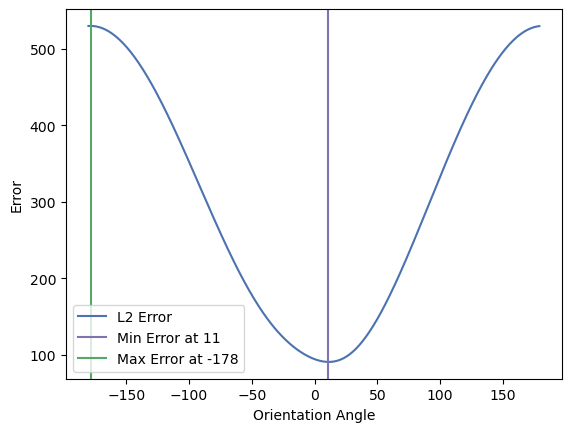

In [41]:
plt.plot(angles, errx, label='L2 Error')
minerr = angles[np.argmin(errx)]
plt.axvline(minerr, c='C3', label='Min Error at {}'.format(minerr))
maxerr = angles[np.argmax(errx)]
plt.axvline(maxerr, c='C1', label='Max Error at {}'.format(maxerr))
plt.legend()
plt.xlabel('Orientation Angle')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

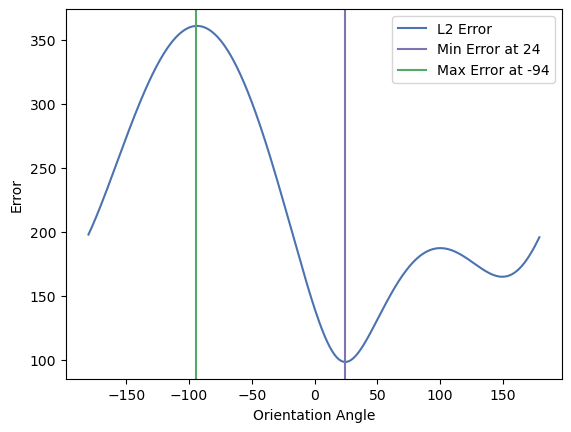

In [42]:
plt.plot(angles, erry, label='L2 Error')
minerr = angles[np.argmin(erry)]
plt.axvline(minerr, c='C3', label='Min Error at {}'.format(minerr))
maxerr = angles[np.argmax(erry)]
plt.axvline(maxerr, c='C1', label='Max Error at {}'.format(maxerr))
plt.legend()
plt.xlabel('Orientation Angle')
plt.ylabel('Error')

In [43]:
angles = np.arange(-180,180)
err = np.zeros(len(angles))

for ii, angle in enumerate(angles):
    
    tmp = correctSonicOrientation(sonic, angle)
    tmp = xr.DataArray(data=tmp, coords=sonic.coords, attrs=sonic.attrs)
    
    err[ii] = np.linalg.norm(atVec - tmp)


Text(0, 0.5, 'Error')

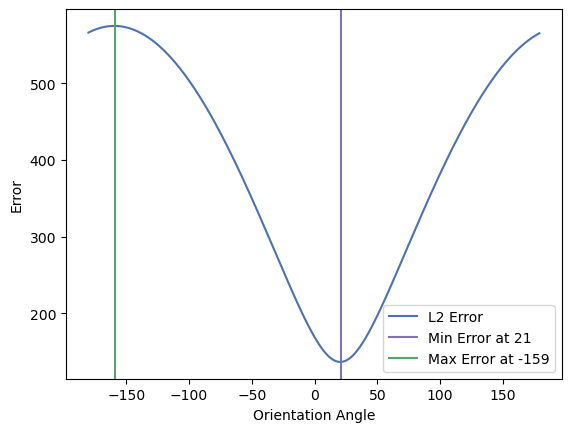

In [44]:
plt.plot(angles, err, label='L2 Error')
minerr = angles[np.argmin(err)]
plt.axvline(minerr, c='C3', label='Min Error at {}'.format(minerr))
maxerr = angles[np.argmax(err)]
plt.axvline(maxerr, c='C1', label='Max Error at {}'.format(maxerr))
plt.legend()
plt.xlabel('Orientation Angle')
plt.ylabel('Error')

In [45]:
sonicMinErr = correctSonicOrientation(sonic, minerr)
sonicMinErr = xr.DataArray(data=sonicMinErr, coords=sonic.coords, attrs=sonic.attrs)
sonicMaxErr = correctSonicOrientation(sonic, maxerr)
sonicMaxErr = xr.DataArray(data=sonicMaxErr, coords=sonic.coords, attrs=sonic.attrs)

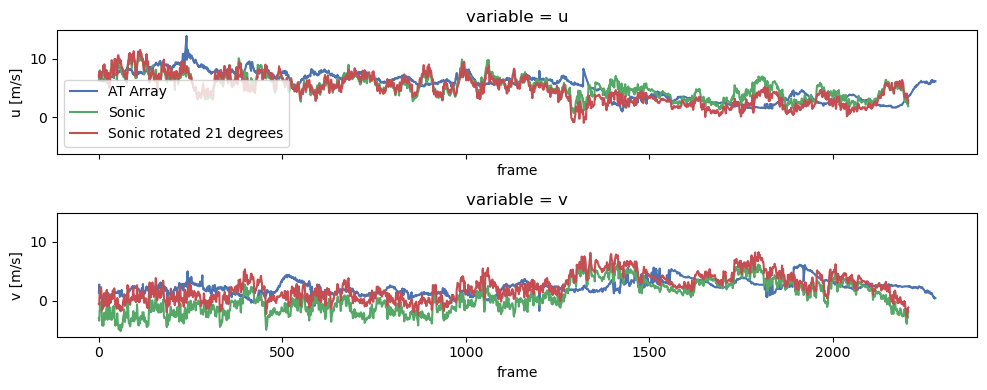

In [46]:
fig, ax = plt.subplots(2,1,sharex=True, sharey=True, figsize=(10,4))

atVec[0].plot(ax=ax[0], label='AT Array')
sonic[0].plot(ax=ax[0], label='Sonic')
sonicMinErr[0].plot(ax=ax[0], label=f'Sonic rotated {minerr} degrees')
ax[0].set_ylabel('u [m/s]')
ax[0].legend()

atVec[1].plot(ax=ax[1])
sonic[1].plot(ax=ax[1], label='Sonic')
sonicMinErr[1].plot(ax=ax[1], label=f'Sonic rotated {minerr} degrees')
ax[1].set_ylabel('v [m/s]')

fig.tight_layout()
